Hate Speech Classification using Large Language Model <br> Persona Analysis of Tweets <br> Text Summarization (Extractive Approach) <br>
By: Lie Reubensto

# Hate Speech Classification using Large Language Model

In [1]:
# Run only when you don't have these modules
# !pip install -U sentence-transformers
# !pip install optuna
# !pip install rouge
# !pip install yellowbrick
# !pip install gensim
# !pip install wordcloud
# !pip install networkx
# !pip install rouge

In [82]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sentence_transformers import SentenceTransformer

import optuna
from optuna import Trial

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
import networkx as nx
from rouge import Rouge
from wordcloud import WordCloud

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ruben\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load Data
df_1 = pd.read_csv('./data_1A.csv', index_col=0)

In [4]:
# See first five rows of data
df_1.head()

,index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,11322,Yg mana di sekolah katolik tak pernah ada. Gw ...,0,0,0,0,0,0,0,0,0
1,1001,USER USER USER USER USER &lt;strong&gt;DASAR C...,1,1,0,1,0,0,0,0,1
2,3070,19.pemimpindarimasjid adalah pemimpin yg dapat...,1,0,0,1,1,0,0,0,0
3,6687,"Kali ini saya angkat jempol sama USER , bukan ...",0,0,0,0,0,0,0,0,0
4,948,USER USER Siapa yang bilang jadi kapir emang s...,1,1,1,0,1,0,0,0,0


In [5]:
# Check data information
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3292 entries, 0 to 3291
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          3292 non-null   int64 
 1   Tweet          3292 non-null   object
 2   HS             3292 non-null   int64 
 3   Abusive        3292 non-null   int64 
 4   HS_Individual  3292 non-null   int64 
 5   HS_Group       3292 non-null   int64 
 6   HS_Religion    3292 non-null   int64 
 7   HS_Race        3292 non-null   int64 
 8   HS_Physical    3292 non-null   int64 
 9   HS_Gender      3292 non-null   int64 
 10  HS_Other       3292 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 308.6+ KB


In [6]:
# Count hoy many rows each type has (since a row can have more than one type, this is just for reference)
type_count = pd.DataFrame()
type_count['type'] = df_1.columns[2:]
type_count['count'] = df_1.iloc[:,2:].sum().values
type_count.sort_values(['count'], inplace=True, ascending=False)
type_count.reset_index(inplace=True, drop=True)
type_count.head(9)

,type,count
0,HS,1426
1,Abusive,1275
2,HS_Other,940
3,HS_Individual,887
4,HS_Group,539
5,HS_Religion,215
6,HS_Race,153
7,HS_Physical,85
8,HS_Gender,84


In [7]:
# The sum of the value of columns in a row 
# (number on left indicates total sum of columns in row, while the number on right indicates how many rows have that sum)
# (the bigger the total sum, the more hate speech type that 'row' involved in)
row_sum = df_1.iloc[:,2:].sum(axis=1)
multilabel_count = row_sum.value_counts()
multilabel_count

0    1417
4     816
3     580
1     449
5      29
6       1
Name: count, dtype: int64

In [8]:
# Checkpoint 1
df_1a = df_1.copy()

In [9]:
# Cleansing Text Function
def cleansing(df):
  df = [i.strip() for i in df]
  df = [i.casefold() for i in df]

  df = [re.sub(r"[^\x00-\x7F]+", "", i) for i in df]
  df = [re.sub(r"[^a-z\s]", "", i) for i in df]
  df = [re.sub(r"\d+", "", i) for i in df] # angka
  df = [re.sub("\b-\b|(?<=\s)-|-(?=\s)", "", i) for i in df]
  df = [re.sub(r"[^\w\s-]", " ", i) for i in df]
  df = [re.sub(r"\s+", " ", i) for i in df]
  df = [re.sub(r"http\S+", "", i) for i in df]
  df = [re.sub(r"&\S+", "", i) for i in df]
  df = [re.sub(r"#\S+", "", i) for i in df]

  df = [re.sub(r"\brt\b", "", i) for i in df]
  df = [re.sub(r"\burl\b", "", i) for i in df]
  df = [re.sub(r"\buser\b", "", i) for i in df]

  df = [re.sub(r"\bad\s\b", "ada ", i) for i in df]
  df = [re.sub(r"\bap\s\b", "apa ", i) for i in df]
  df = [re.sub(r"\badlh\b", "adalah", i) for i in df]
  df = [re.sub(r"\bdg\s\b", "dengan ", i) for i in df]
  df = [re.sub(r"\bbgt\b", "banget", i) for i in df]
  df = [re.sub(r"\bdgn\b", "dengan", i) for i in df]
  df = [re.sub(r"\bdri\b", "dari", i) for i in df]
  df = [re.sub(r"\bemg\b", "emang", i) for i in df]
  df = [re.sub(r"\bgt\s\b", "gitu ", i) for i in df]
  df = [re.sub(r"\bjd\s\b", "jadi ", i) for i in df]
  df = [re.sub(r"\bjdi\b", "jadi", i) for i in df]
  df = [re.sub(r"\bjg\s\b", "jangan ", i) for i in df]
  df = [re.sub(r"\bjgn\b", "jangan", i) for i in df]
  df = [re.sub(r"\bklo\b", "kalau", i) for i in df]
  df = [re.sub(r"\bsdh\b", "sudah", i) for i in df]
  df = [re.sub(r"\btau\b", "tahu", i) for i in df]
  df = [re.sub(r"\btdk\b", "tidak", i) for i in df]
  df = [re.sub(r"\btpi\b", "tapi", i) for i in df]
  df = [re.sub(r"\butk\b", "untuk", i) for i in df]
  df = [re.sub(r"\byg\b", "yang", i) for i in df]

  df = [i.strip() for i in df]
  return df

In [10]:
# Perform cleansing and store the clean tweet in a different column
df_1a['Clean_Tweet'] = cleansing(df_1a['Tweet'])

In [11]:
# Calculate the length of each tweet and store the value in a different column
df_1a['Length'] = df_1a['Clean_Tweet'].apply(lambda i: len(i.split()))

In [12]:
# Check the new data
df_1a.head()

,index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,Clean_Tweet,Length
0,11322,Yg mana di sekolah katolik tak pernah ada. Gw ...,0,0,0,0,0,0,0,0,0,yang mana di sekolah katolik tak pernah ada gw...,20
1,1001,USER USER USER USER USER &lt;strong&gt;DASAR C...,1,1,0,1,0,0,0,0,1,ltstronggtdasar cebong dungu turunanltstronggt,4
2,3070,19.pemimpindarimasjid adalah pemimpin yg dapat...,1,0,0,1,1,0,0,0,0,pemimpindarimasjid adalah pemimpin yang dapat ...,17
3,6687,"Kali ini saya angkat jempol sama USER , bukan ...",0,0,0,0,0,0,0,0,0,kali ini saya angkat jempol sama bukan pada s...,35
4,948,USER USER Siapa yang bilang jadi kapir emang s...,1,1,1,0,1,0,0,0,0,siapa yang bilang jadi kapir emang susah hahah...,38


In [13]:
# Checkpoint 2
df_1b = df_1a.copy()

In [14]:
# Load Sentence Transformer and apply sentence embeddings from that model
sentence_embed_model = SentenceTransformer('firqaaa/indo-sentence-bert-base') # Indonesian Bert-based model since the data is in Indonesian
sentence_embeddings = sentence_embed_model.encode(df_1b['Clean_Tweet'])

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Max Sequence Length: 47


In [15]:
# Split data to training and testing data
col = [i for i in df_1b.columns[2:11]] # hate speech type columns
x_train1, x_test, y_train1, y_test = train_test_split(sentence_embeddings, df_1b[col], train_size=0.9, random_state=42, stratify=df_1b['HS'])

In [16]:
# Define obejctive function
def objective(trial):
    keras.backend.clear_session()
    x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=1/9, random_state=42, stratify=y_train1['HS'])

    # Number of Hidden Layers
    n_layers = trial.suggest_int('n_layers', 1, 2)

    model = keras.Sequential()

    for i in range(n_layers):
        # Number of Hidden Nodes
        num_hidden = trial.suggest_int(f'n_units_layer{i}', 12, len(sentence_embeddings[0]), log=True)
        # Activation Function
        model.add(keras.layers.Dense(num_hidden, input_shape=(len(sentence_embeddings[0]), ), activation=trial.suggest_categorical(f'activation_layer{i}', ['relu', 'linear'])))
        # Dropout Value
        model.add(keras.layers.Dropout(rate=trial.suggest_float(f'dropout_layer{i}', 0.3, 0.5)))

    # Output Layer
    model.add(keras.layers.Dense(9, activation='sigmoid'))

    val_data = (x_val, y_val)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=2)
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=2, mode="auto", baseline=None, restore_best_weights=True)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')

    # Batch Size
    history = model.fit(x_train, y_train, validation_data=val_data, epochs=5, callbacks=[reduce_lr,early_stopping],verbose=0, batch_size=trial.suggest_int('batch_size', 8, 16))

    return min(history.history['val_loss'])

In [17]:
# Optimization of model
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))

[I 2024-10-22 13:50:01,086] A new study created in memory with name: no-name-33ac5e10-7369-4f1c-9075-0224266986c8
[I 2024-10-22 13:50:05,181] Trial 0 finished with value: 0.2886499762535095 and parameters: {'n_layers': 2, 'n_units_layer0': 206, 'activation_layer0': 'linear', 'dropout_layer0': 0.45053481675403373, 'n_units_layer1': 41, 'activation_layer1': 'relu', 'dropout_layer1': 0.46200008817877125, 'batch_size': 10}. Best is trial 0 with value: 0.2886499762535095.
[I 2024-10-22 13:50:07,364] Trial 1 finished with value: 0.2854861319065094 and parameters: {'n_layers': 1, 'n_units_layer0': 45, 'activation_layer0': 'linear', 'dropout_layer0': 0.40083541920665017, 'batch_size': 15}. Best is trial 1 with value: 0.2854861319065094.
[I 2024-10-22 13:50:10,052] Trial 2 finished with value: 0.2900737226009369 and parameters: {'n_layers': 2, 'n_units_layer0': 27, 'activation_layer0': 'linear', 'dropout_layer0': 0.45642189477149697, 'n_units_layer1': 123, 'activation_layer1': 'linear', 'dropou


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


[I 2024-10-22 13:50:43,727] Trial 14 finished with value: 0.26338428258895874 and parameters: {'n_layers': 1, 'n_units_layer0': 167, 'activation_layer0': 'relu', 'dropout_layer0': 0.4269820050368915, 'batch_size': 13}. Best is trial 11 with value: 0.25397011637687683.
[I 2024-10-22 13:50:48,607] Trial 15 finished with value: 0.25370460748672485 and parameters: {'n_layers': 1, 'n_units_layer0': 368, 'activation_layer0': 'relu', 'dropout_layer0': 0.37222962531989257, 'batch_size': 13}. Best is trial 15 with value: 0.25370460748672485.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


[I 2024-10-22 13:50:55,823] Trial 16 finished with value: 0.2640477120876312 and parameters: {'n_layers': 1, 'n_units_layer0': 667, 'activation_layer0': 'relu', 'dropout_layer0': 0.3613116777856501, 'batch_size': 11}. Best is trial 15 with value: 0.25370460748672485.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


[I 2024-10-22 13:51:02,965] Trial 17 finished with value: 0.261470764875412 and parameters: {'n_layers': 1, 'n_units_layer0': 391, 'activation_layer0': 'relu', 'dropout_layer0': 0.3768810130584954, 'batch_size': 8}. Best is trial 15 with value: 0.25370460748672485.
[I 2024-10-22 13:51:05,855] Trial 18 finished with value: 0.2601594030857086 and parameters: {'n_layers': 1, 'n_units_layer0': 328, 'activation_layer0': 'relu', 'dropout_layer0': 0.38186912211130547, 'batch_size': 16}. Best is trial 15 with value: 0.25370460748672485.



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


[I 2024-10-22 13:51:08,453] Trial 19 finished with value: 0.2518094480037689 and parameters: {'n_layers': 1, 'n_units_layer0': 264, 'activation_layer0': 'relu', 'dropout_layer0': 0.3002739378336866, 'batch_size': 14}. Best is trial 19 with value: 0.2518094480037689.


Number of finished trials: 20
Best trial:
Value: 0.2518094480037689


In [18]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)

In [19]:
# Print best value for each hyperparameters
print("Best Hyper Parameters:")
for key, value in trial.params.items():
  print("{}: {}".format(key, value))

Best Hyper Parameters:
n_layers: 1
n_units_layer0: 264
activation_layer0: relu
dropout_layer0: 0.3002739378336866
batch_size: 14


In [20]:
# Apply what we jnow from the optimization before (batch size will be applied later when model fitting/training)
def optimal_model():
    model = keras.Sequential()
    model.add(layers.Dense(264, input_shape=(len(sentence_embeddings[0]), ), activation='relu'))
    model.add(layers.Dropout(0.3002739378336866))
    model.add(layers.Dense(9, activation='sigmoid'))
    return model

In [21]:
# Split training data to Training and Valiadtion Data and Preparing model
keras.backend.clear_session()

x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=1/9, random_state=42, stratify=y_train1['HS'])

model = optimal_model()

val_data = (x_val, y_val)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-06, verbose=2)
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=2, mode="auto", baseline=None, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')

In [22]:
# Mdeol Training
history = model.fit(x_train, y_train, validation_data=val_data, epochs=10, callbacks=[reduce_lr, early_stopping], verbose=2, batch_size=14)

Epoch 1/10
188/188 - 1s - loss: 0.3410 - binary_accuracy: 0.8466 - val_loss: 0.2801 - val_binary_accuracy: 0.8822 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 2/10
188/188 - 0s - loss: 0.2529 - binary_accuracy: 0.8890 - val_loss: 0.2669 - val_binary_accuracy: 0.8848 - lr: 0.0010 - 481ms/epoch - 3ms/step
Epoch 3/10
188/188 - 0s - loss: 0.2172 - binary_accuracy: 0.9069 - val_loss: 0.2603 - val_binary_accuracy: 0.8973 - lr: 0.0010 - 363ms/epoch - 2ms/step
Epoch 4/10
188/188 - 0s - loss: 0.1866 - binary_accuracy: 0.9212 - val_loss: 0.2543 - val_binary_accuracy: 0.8875 - lr: 0.0010 - 383ms/epoch - 2ms/step
Epoch 5/10
188/188 - 0s - loss: 0.1615 - binary_accuracy: 0.9349 - val_loss: 0.2641 - val_binary_accuracy: 0.8953 - lr: 0.0010 - 402ms/epoch - 2ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
188/188 - 0s - loss: 0.1424 - binary_accuracy: 0.9435 - val_loss: 0.2684 - val_binary_accuracy: 0.8923 - lr: 0.0010 - 413ms/epoch - 2ms/step
Epoch 7/10
18

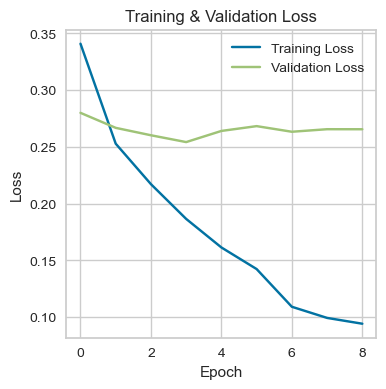

In [23]:
# Plot Training History
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [33]:
# Model Evaluation
pred_test = model.predict(x_test)
print(f"Real Predictions: {pred_test}\n")
pred_test = tf.where(pred_test < 0.5, 0, 1)
print(f"Predictions:\n{pred_test}\n")
print(f"Real:\n{y_test.to_numpy()}")

acc_test = accuracy_score(y_test, pred_test)
prec_test = precision_score(y_test, pred_test, average='weighted')
rec_test = recall_score(y_test, pred_test, average='weighted')
f1_test = f1_score(y_test, pred_test, average='weighted')

print("\n-- Testing Result --")
print(f"> Accuracy: {acc_test:.3f}")
print(f"> Precision: {prec_test:.3f}")
print(f"> Recall: {rec_test:.3f}")
print(f"> F1 Score: {f1_test:.3f}")

11/11 [==============================] - 0s 2ms/step
Real Predictions: [[9.8707408e-01 6.2420517e-01 8.4871453e-01 ... 3.4153770e-04
  5.0285142e-03 9.7500926e-01]
 [7.6791951e-03 5.3010695e-04 7.3226574e-03 ... 5.6939782e-04
  3.9214711e-03 4.5706397e-03]
 [4.3800482e-01 8.0913887e-04 1.1081296e-02 ... 6.8093100e-06
  5.1158622e-05 1.0624737e-02]
 ...
 [8.7285154e-02 9.0365767e-01 2.6688466e-02 ... 1.4220163e-03
  2.1406657e-03 5.1049657e-02]
 [1.4166219e-02 3.0269083e-01 2.7370123e-02 ... 1.6812058e-03
  4.5218137e-03 3.6444250e-03]
 [9.0154016e-01 9.4176090e-01 6.1199605e-01 ... 1.1142643e-01
  8.6980693e-02 2.5429952e-01]]

Predictions:
[[1 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]

Real:
[[1 0 1 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 1]]

-- Testing Result --
> Accuracy: 0.512
> Precision: 0.728
> Recall: 0.659
> F1 Score: 0.678


# Persona Analysis of Tweets

In [34]:
# Load Data
df_2 = pd.read_csv('./data_2A.csv', index_col=0)

In [35]:
# See first five rows of data
df_2.head()

,index,URL,Date,Tweet,ID,Username,Replies,Reetweets,Likes,Quotes,conversationId,Language,Links,Media,Retweeted Tweet,Bookmarks
0,20245,https://twitter.com/joann_aph/status/165623854...,2023-05-10 10:03:36+00:00,@bankbsi_id besok tutup ajalah masa maintenanc...,1656238548792807424,joann_aph,2,0,0,0,1656238548792807424,in,NaN,NaN,NaN,0
1,5310,https://twitter.com/PartaiSocmed/status/165760...,2023-05-14 04:50:13+00:00,@win2_winner @bankbsi_id @HaloBCA @BANKBRI_ID ...,1657609236870836226,PartaiSocmed,7,0,2,3,1657601388443049986,in,NaN,NaN,NaN,0
2,19500,https://twitter.com/reeeezki/status/1656266869...,2023-05-10 11:56:08+00:00,"@bankbsi_id udahan dong erornya, udah berapa h...",1656266869337391104,reeeezki,0,0,0,0,1656266869337391104,in,NaN,NaN,NaN,0
3,9567,https://twitter.com/farid_wajdi70/status/16572...,2023-05-13 06:03:43+00:00,Semoga segera ada solusi terbaik @YLKI_ID @ojk...,1657265343776325633,farid_wajdi70,0,0,0,0,1657265343776325633,in,NaN,NaN,NaN,0
4,10154,https://twitter.com/rudinosaurs/status/1657236...,2023-05-13 04:09:45+00:00,@secgron @bankbsi_id Udah lama gw tinggalin ni...,1657236663972802565,rudinosaurs,0,0,1,0,1657192354829451264,in,NaN,NaN,NaN,0


In [36]:
# Check data information
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6100 entries, 0 to 6099
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            6100 non-null   int64  
 1   URL              6100 non-null   object 
 2   Date             6100 non-null   object 
 3   Tweet            6100 non-null   object 
 4   ID               6100 non-null   int64  
 5   Username         6100 non-null   object 
 6   Replies          6100 non-null   int64  
 7   Reetweets        6100 non-null   int64  
 8   Likes            6100 non-null   int64  
 9   Quotes           6100 non-null   int64  
 10  conversationId   6100 non-null   int64  
 11  Language         6100 non-null   object 
 12  Links            220 non-null    object 
 13  Media            555 non-null    object 
 14  Retweeted Tweet  0 non-null      float64
 15  Bookmarks        6100 non-null   int64  
dtypes: float64(1), int64(8), object(7)
memory usage: 810.2+ KB


In [37]:
# Checkpoin 1
df_2a = df_2.copy()

In [38]:
# Drop every column, except 'Tweet'
df_2a.drop(df_2a.columns.difference(['Tweet']), axis=1, inplace=True)

In [39]:
# Check new data
df_2a

,Tweet
0,@bankbsi_id besok tutup ajalah masa maintenanc...
1,@win2_winner @bankbsi_id @HaloBCA @BANKBRI_ID ...
2,"@bankbsi_id udahan dong erornya, udah berapa h..."
3,Semoga segera ada solusi terbaik @YLKI_ID @ojk...
4,@secgron @bankbsi_id Udah lama gw tinggalin ni...
...,...
6095,"@bankbsi_id udah 3hari loh, atm+mbanking berma..."
6096,@bankbsi_id sampai kapan nih M banking nya tid...
6097,@nmonarizqa @bankbsi_id tuh baca baik2
6098,@kepolukekdoraaa @gorengapi @bankbsi_id dicek ...


In [41]:
# Cleansing Text Function
def cleansing(df):
  df = [i.strip() for i in df]
  df = [i.casefold() for i in df]

  df = [re.sub(r"[^\x00-\x7F]+", "", i) for i in df]
  df = [re.sub(r"[^a-z\s]", "", i) for i in df]
  df = [re.sub(r"\d+", "", i) for i in df] # angka
  df = [re.sub("\b-\b|(?<=\s)-|-(?=\s)", "", i) for i in df]
  df = [re.sub(r"[^\w\s-]", " ", i) for i in df]
  df = [re.sub(r"\s+", " ", i) for i in df]
  df = [re.sub(r"http\S+", "", i) for i in df]
  df = [re.sub(r"&\S+", "", i) for i in df]
  df = [re.sub(r"#\S+", "", i) for i in df]

  df = [re.sub(r"\brt\b", "", i) for i in df]
  df = [re.sub(r"\burl\b", "", i) for i in df]
  df = [re.sub(r"\buser\b", "", i) for i in df]

  df = [re.sub(r"\bad\s\b", "ada ", i) for i in df]
  df = [re.sub(r"\bap\s\b", "apa ", i) for i in df]
  df = [re.sub(r"\badlh\b", "adalah", i) for i in df]
  df = [re.sub(r"\bdg\s\b", "dengan ", i) for i in df]
  df = [re.sub(r"\bbgt\b", "banget", i) for i in df]
  df = [re.sub(r"\bdgn\b", "dengan", i) for i in df]
  df = [re.sub(r"\bdri\b", "dari", i) for i in df]
  df = [re.sub(r"\bemg\b", "emang", i) for i in df]
  df = [re.sub(r"\bgt\s\b", "gitu ", i) for i in df]
  df = [re.sub(r"\bjd\s\b", "jadi ", i) for i in df]
  df = [re.sub(r"\bjdi\b", "jadi", i) for i in df]
  df = [re.sub(r"\bjg\s\b", "jangan ", i) for i in df]
  df = [re.sub(r"\bjgn\b", "jangan", i) for i in df]
  df = [re.sub(r"\bklo\b", "kalau", i) for i in df]
  df = [re.sub(r"\bsdh\b", "sudah", i) for i in df]
  df = [re.sub(r"\btau\b", "tahu", i) for i in df]
  df = [re.sub(r"\btdk\b", "tidak", i) for i in df]
  df = [re.sub(r"\btpi\b", "tapi", i) for i in df]
  df = [re.sub(r"\butk\b", "untuk", i) for i in df]
  df = [re.sub(r"\byg\b", "yang", i) for i in df]

  df = [i.strip() for i in df]
  return df

In [42]:
# Apply cleansing text and store it in a new column
df_2a['Clean_Tweet'] = cleansing(df_2a['Tweet'])

In [43]:
# Check new data
df_2a

,Tweet,Clean_Tweet
0,@bankbsi_id besok tutup ajalah masa maintenanc...,bankbsiid besok tutup ajalah masa maintenance ...
1,@win2_winner @bankbsi_id @HaloBCA @BANKBRI_ID ...,winwinner bankbsiid halobca bankbriid muipusat...
2,"@bankbsi_id udahan dong erornya, udah berapa h...",bankbsiid udahan dong erornya udah berapa hari...
3,Semoga segera ada solusi terbaik @YLKI_ID @ojk...,semoga segera ada solusi terbaik ylkiid ojkind...
4,@secgron @bankbsi_id Udah lama gw tinggalin ni...,secgron bankbsiid udah lama gw tinggalin ni ba...
...,...,...
6095,"@bankbsi_id udah 3hari loh, atm+mbanking berma...",bankbsiid udah hari loh atmmbanking bermasalah...
6096,@bankbsi_id sampai kapan nih M banking nya tid...,bankbsiid sampai kapan nih m banking nya tidak...
6097,@nmonarizqa @bankbsi_id tuh baca baik2,nmonarizqa bankbsiid tuh baca baik
6098,@kepolukekdoraaa @gorengapi @bankbsi_id dicek ...,kepolukekdoraaa gorengapi bankbsiid dicek berk...


In [44]:
# Checkpoint 2
df_2b = df_2a.copy()

In [85]:
# Split 'X' data to X training and X testing
x_train, x_test = train_test_split(df_2b['Clean_Tweet'], test_size=0.2, random_state=42)

In [46]:
# Apply text representation TF-IDF
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
train_tfidf = pd.DataFrame(x_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
train_tfidf.head()

,aaaa,aaaaaaaaaa,aafauzie,aag,aahhh,aaja,aamiin,aanfr,aanndtrr,aapalagi,...,zonabanabila,zonajajan,zonauang,zone,zonk,zulaykhsh,zulfamuu,zulqarnaiyn,zuzur,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


n_clusters = 2 , average silhouette_score: 0.004751268006177332
n_clusters = 3 , average silhouette_score: 0.0033663144106629416
n_clusters = 4 , average silhouette_score: 0.004027438805116921
n_clusters = 5 , average silhouette_score: 0.00380780695967905
n_clusters = 6 , average silhouette_score: 0.004056997428387665
n_clusters = 7 , average silhouette_score: 0.004429629558912096
n_clusters = 8 , average silhouette_score: 0.005424259372864249
n_clusters = 9 , average silhouette_score: 0.006231561523173521
n_clusters = 10 , average silhouette_score: 0.006238389102625406


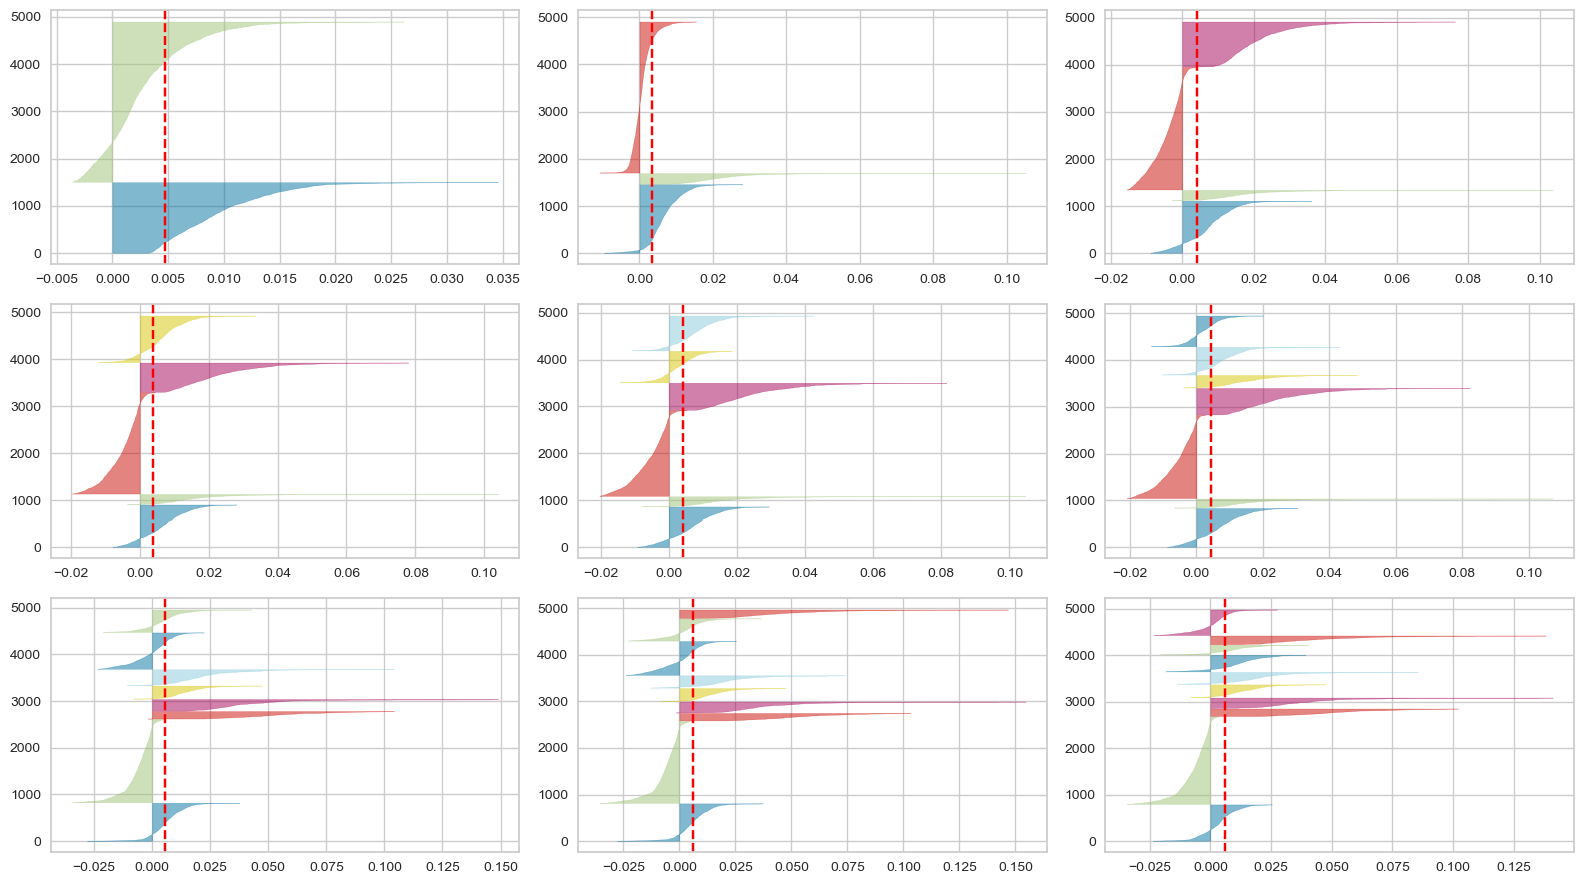

In [48]:
# Find the right number of cluster with silhouette score approach
distortions = []
K = range(2, 11) # K from 2 to 10 'clusters'
fig, ax = plt.subplots(3, 3, figsize=(16,9))
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=99)
    q, mod = divmod(k-2, 3)
    cluster_label = kmeans_model.fit_predict(train_tfidf)
    # Calculate silhouette_score for each cluster
    silhouette_avg = silhouette_score(train_tfidf, cluster_label)
    print("n_clusters =", k, ", average silhouette_score:", silhouette_avg)
    # kmeans inertia_ attribute is:  Sum of squared distances of samples # to their closest cluster center.
    distortions.append(kmeans_model.inertia_)
    visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(train_tfidf)

plt.tight_layout()
plt.show()

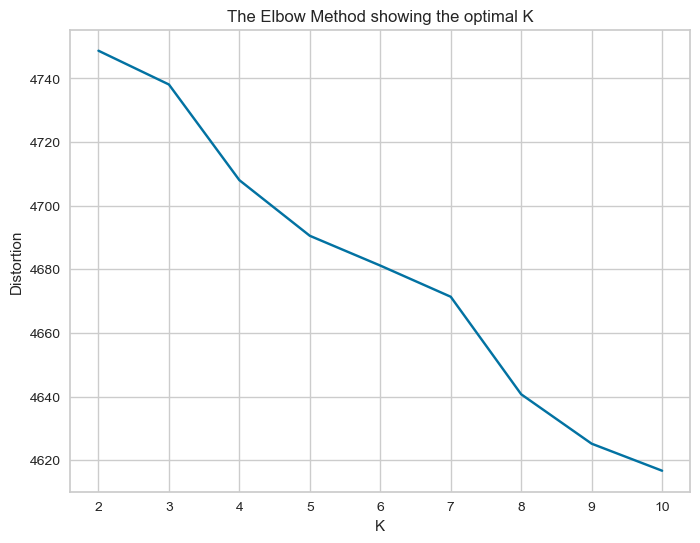

In [49]:
# Plot Elbow Graph
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

In [50]:
# Based on Silhouette Score and Elbow Method, cluster 10 is the best one
# Cluster 10 gives the best silhouette score (albeit still poor)
# The elbow graph also doesn't give a great information, since it's hard to see the actual good 'elbow' part
k_best = 10
kmeanModel = KMeans(n_clusters=k_best, random_state=42)
kmeanModel.fit(train_tfidf)

KMeans(n_clusters=10, random_state=42)

In [86]:
# Convert x_train to dataframe and reset the indexing
x_train = pd.DataFrame(x_train).reset_index()

In [87]:
# Predict which cluster the tweet belongs to
x_train['cluster'] = kmeanModel.predict(train_tfidf)

In [88]:
# See the result
x_train.head()

,index,Clean_Tweet,cluster
0,5381,bankbsiid mobile banking error bermasalah teru...,1
1,3921,bsi bank paling keren hari error anjing mana g...,9
2,2107,secgron bankbsiid kok jago jago kali ya orang ...,1
3,485,rochmatpurwanto gankofpetojo bankbsiid jangan ...,2
4,4154,borryshasian bankbsiid bankbca mas nya sial da...,1


In [89]:
# Apply the same methods as training from before to testing data (without the predicting part)
x_test = pd.DataFrame(x_test).reset_index()
x_test.head()

,index,Clean_Tweet
0,2794,gajahsetia bankbsiid berangsur pulih tapi traf...
1,2592,dinamsdamanik alicebb bankbsiid iya itu scam
2,5355,direktur utama bank syariah indonesia atau bsi...
3,2002,nopal secgron bankbsiid nyebar hoax bisa kena ...
4,4205,dennydn fuad mouldiesep bankbsiid ya harus dia...


In [90]:
# Apply the TF-IDF text representation to testing data
test_tfidf = vectorizer.transform(x_test['Clean_Tweet'])

In [91]:
# See the TF-IDF of testing data
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
test_tfidf.head()

,aaaa,aaaaaaaaaa,aafauzie,aag,aahhh,aaja,aamiin,aanfr,aanndtrr,aapalagi,...,zonabanabila,zonajajan,zonauang,zone,zonk,zulaykhsh,zulfamuu,zulqarnaiyn,zuzur,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Predict the cluster to which the tweet in testing data belongs to
x_test['cluster'] = kmeanModel.predict(test_tfidf)

In [93]:
# See the new testing data
x_test.head()

,index,Clean_Tweet,cluster
0,2794,gajahsetia bankbsiid berangsur pulih tapi traf...,0
1,2592,dinamsdamanik alicebb bankbsiid iya itu scam,1
2,5355,direktur utama bank syariah indonesia atau bsi...,9
3,2002,nopal secgron bankbsiid nyebar hoax bisa kena ...,1
4,4205,dennydn fuad mouldiesep bankbsiid ya harus dia...,1


In [94]:
# Unite the Training and Testing data
x_unite = pd.concat([x_train, x_test])
x_unite.head()

,index,Clean_Tweet,cluster
0,5381,bankbsiid mobile banking error bermasalah teru...,1
1,3921,bsi bank paling keren hari error anjing mana g...,9
2,2107,secgron bankbsiid kok jago jago kali ya orang ...,1
3,485,rochmatpurwanto gankofpetojo bankbsiid jangan ...,2
4,4154,borryshasian bankbsiid bankbca mas nya sial da...,1


In [95]:
# Drop 'Index' column
x_unite.drop(columns=x_unite.columns[0], axis=1, inplace=True)

In [96]:
# See the change
x_unite.head()

,Clean_Tweet,cluster
0,bankbsiid mobile banking error bermasalah teru...,1
1,bsi bank paling keren hari error anjing mana g...,9
2,secgron bankbsiid kok jago jago kali ya orang ...,1
3,rochmatpurwanto gankofpetojo bankbsiid jangan ...,2
4,borryshasian bankbsiid bankbca mas nya sial da...,1


In [97]:
# Checkpoint 3
x_unite_1 = x_unite.copy()

In [98]:
# Preprocess the tweets
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("indonesian"))

def preprocess(tweet):
  tweet = tweet.lower()
  words = word_tokenize(tweet)
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return words

x_unite_1['Clean_Tweet'] = x_unite_1['Clean_Tweet'].astype(str).apply(preprocess)

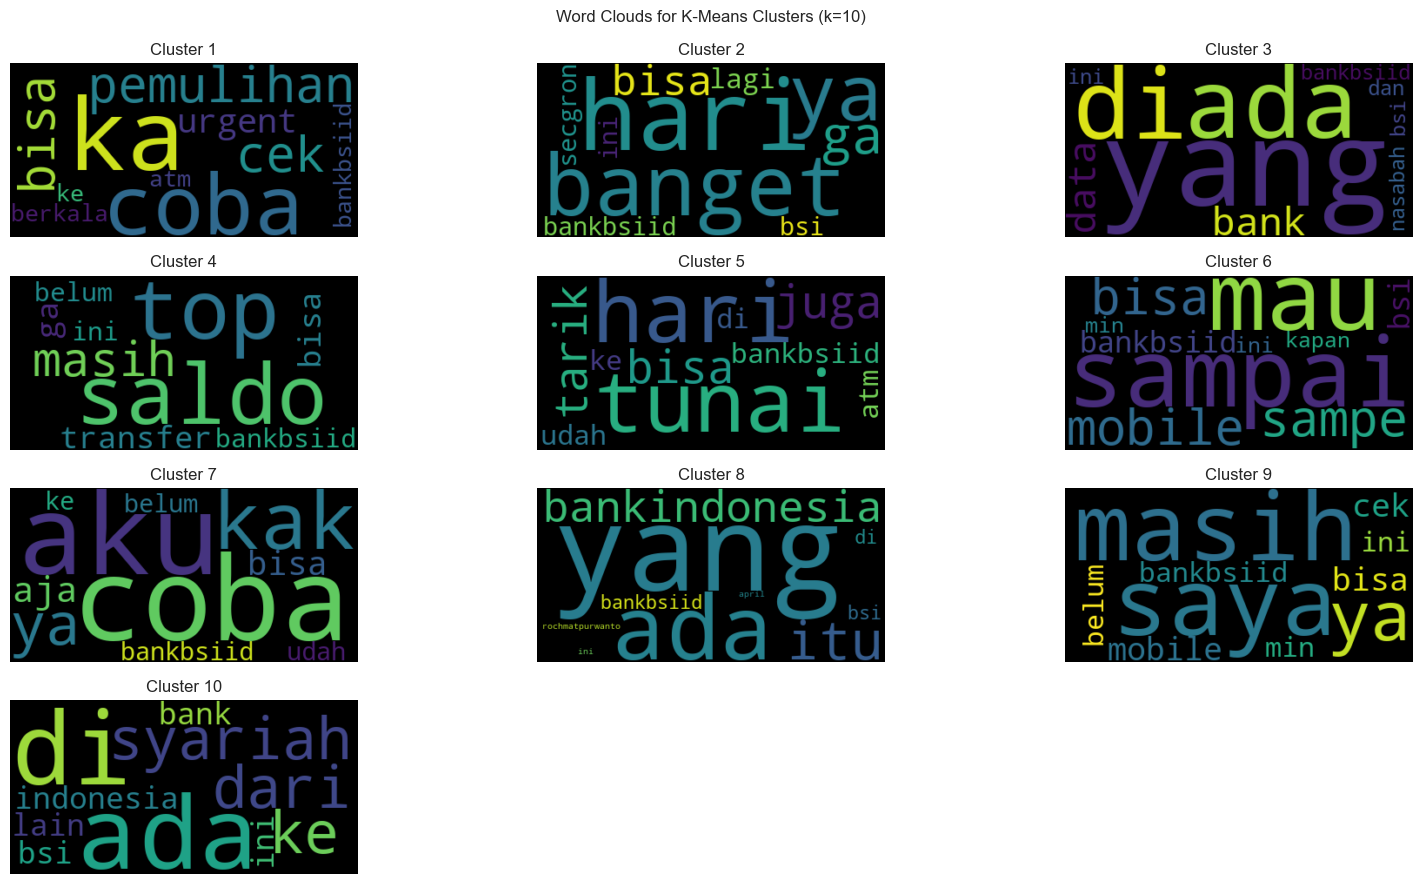

In [99]:
# Plotting of feature names in each cluster
silhouette_best = 0.006238389102625406
best_model = kmeanModel

plt.figure(figsize=(16,9))
for cluster in range(k_best):
  plt.subplot(4, 3, cluster + 1)
  cluster_words = set()
  # Ambil Top 10 Kata
  top_features_idx = best_model.cluster_centers_[cluster].argsort()[::-1][:10]
  for idx in top_features_idx:
      cluster_words.add(vectorizer.get_feature_names_out()[idx])
  cluster_words_str = ' '.join(cluster_words)
  wordcloud = WordCloud().generate(cluster_words_str)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Cluster {cluster + 1}')
  plt.axis('off')

plt.suptitle(f'Word Clouds for K-Means Clusters (k={k_best})', fontsize=12)
plt.tight_layout()
plt.show()

In [101]:
# Create a dictionary from the preprocessed data
dictionary = Dictionary(df_2b['Clean_Tweet'].apply(preprocess))

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(text) for text in x_unite_1['Clean_Tweet']]

# Train the LDA model
ldamodel = LdaModel(bow_corpus, num_topics=k_best, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=k_best, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['saldo', 'transfer', 'bank', 'masuk', 'blm', 'transaksi', 'bsi', 'rekening', 'min', 'dana']
Topic: 1
Words: ['udah', 'kalo', 'gimana', 'nih', 'aja', 'gini', 'penipu', 'min', 'gak', 'secgron']
Topic: 2
Words: ['ga', 'bsi', 'aja', 'bank', 'banking', 'nya', 'udah', 'mobile', 'duit', 'pindah']
Topic: 3
Words: ['kak', 'ya', 'bsi', 'hati', 'akun', 'maaf', 'sabar', 'wa', 'gak', 'call']
Topic: 4
Words: ['sampe', 'error', 'ga', 'maintenance', 'secgron', 'mbanking', 'nya', 'si', 'sih', 'bayar']
Topic: 5
Words: ['cek', 'bsi', 'coba', 'ka', 'alhamdulillah', 'aja', 'saldo', 'ngga', 'mobile', 'kak']
Topic: 6
Words: ['rochmatpurwanto', 'ka', 'secgron', 'semoga', 'udh', 'aja', 'iya', 'aman', 'ya', 'ku']
Topic: 7
Words: ['bsi', 'sistem', 'kendala', 'kasih', 'susah', 'banget', 'gagal', 'it', 'ojkindonesia', 'mobile']
Topic: 8
Words: ['bank', 'bsi', 'syariah', 'nasabah', 'data', 'indonesia', 'aceh', 'gangguan', 'layanan', 'mengalami']
Topic: 9
Words: ['min', 'atm', 'bsi', 'tarik', 'bange

# Text Summarization (Extractive Approach)

In [102]:
# Load Data
df_3 = pd.read_csv('./data_3A.csv', index_col=0)

In [103]:
# See first five rows of data
df_3.head()

,content,summary
0,"TEMPO.CO, Jakarta - Anggota Komisi VII DPR RI ...",Anggota Komisi VII DPR RI Rofik Hananto menyay...
1,"TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Presiden Joko Widodo telah memerintahkan Wakil...
2,INFO NASIONAL - Wakil Ketua MPR RI Dr. H. M. H...,Wakil Ketua MPR RI Dr. H. M. Hidayat Nur Wahid...


In [104]:
# See data information
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3 non-null      object
 1   summary  3 non-null      object
dtypes: object(2)
memory usage: 72.0+ bytes


In [105]:
# Function for removing certain keywords
def remove_keyword(text, keyword):
    escaped_keyword = re.escape(keyword)
    pattern = rf'{escaped_keyword}.*'
    modified_text = re.sub(pattern, '', text, flags=re.IGNORECASE).strip()
    return modified_text

In [106]:
# Apply 'cleansing' of content column data
df_3['content'] = df_3['content'].apply(lambda x: re.sub('TEMPO.CO, Jakarta - ', '', x))
df_3['content'] = df_3['content'].apply(lambda x: remove_keyword(x, 'Pilihan Editor:'))
df_3['content'] = df_3['content'].apply(lambda x: x.strip())

In [107]:
# Reset Indexing of the data
df_3.reset_index(inplace=True)

In [108]:
# Function for sentence similarity matrix builder, scores of sentences ranking, and generating summary
def sentence_similarity_matrix(sentences, stop_words):
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return similarity_matrix

def rank_sentences(similarity_matrix):
    # Build graph and apply PageRank algorithm
    sentence_similarity_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
    return scores

def generate_summary(text, top_n):
    stop_words = stopwords.words('indonesian')
    stop_words.extend(['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])
    summarize_text = []

    sentences = nltk.sent_tokenize(text)
    similarity_matrix = sentence_similarity_matrix(sentences, stop_words)
    scores = rank_sentences(similarity_matrix)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    for i in range(top_n):
        summarize_text.append(ranked_sentences[i][1])

    return " ".join(summarize_text)

In [109]:
# Generate Summary for top 3 and top 5 sentence ranking score
top_3 = []
top_5 = []

for _, r in df_3.iterrows():
    text = r['content']
    summary_top_3 = generate_summary(text, 3)
    top_3.append(summary_top_3)
    summary_top_5 = generate_summary(text, 5)
    top_5.append(summary_top_5)

In [110]:
# STore the value in the main dataframe in new columns
df_3['_top_3'] = top_3
df_3['_top_5'] = top_5

In [111]:
# Calculate Rouge Scores
rouge = Rouge()

for i, (top_3, top_5) in enumerate(zip(top_3, top_5)):
    reference_summary = df_3['summary'][i]
    generated_summary_top_3 = top_3
    generated_summary_top_5 = top_5

    rouge_scores_top_3 = rouge.get_scores(generated_summary_top_3, reference_summary, avg=True)
    rouge_scores_top_5 = rouge.get_scores(generated_summary_top_5, reference_summary, avg=True)

    print(f"\nRow {i+1} ROUGE Scores for Top 3 Sentences:")
    print("Rouge-1:", rouge_scores_top_3['rouge-1'])
    print("Rouge-2:", rouge_scores_top_3['rouge-2'])
    print("Rouge-L:", rouge_scores_top_3['rouge-l'])
    print(f"\nRow {i+1} ROUGE Scores for Top 5 Sentences:")
    print("Rouge-1:", rouge_scores_top_5['rouge-1'])
    print("Rouge-2:", rouge_scores_top_5['rouge-2'])
    print("Rouge-L:", rouge_scores_top_5['rouge-l'])


Row 1 ROUGE Scores for Top 3 Sentences:
Rouge-1: {'r': 0.19444444444444445, 'p': 0.11864406779661017, 'f': 0.14736841634570655}
Rouge-2: {'r': 0.05263157894736842, 'p': 0.02702702702702703, 'f': 0.035714281230867916}
Rouge-L: {'r': 0.19444444444444445, 'p': 0.11864406779661017, 'f': 0.14736841634570655}

Row 1 ROUGE Scores for Top 5 Sentences:
Rouge-1: {'r': 0.5277777777777778, 'p': 0.2087912087912088, 'f': 0.2992125943629488}
Rouge-2: {'r': 0.3684210526315789, 'p': 0.1206896551724138, 'f': 0.18181817810086023}
Rouge-L: {'r': 0.5277777777777778, 'p': 0.2087912087912088, 'f': 0.2992125943629488}

Row 2 ROUGE Scores for Top 3 Sentences:
Rouge-1: {'r': 0.7428571428571429, 'p': 0.45614035087719296, 'f': 0.5652173865902647}
Rouge-2: {'r': 0.5789473684210527, 'p': 0.34375, 'f': 0.4313725443444829}
Rouge-L: {'r': 0.7428571428571429, 'p': 0.45614035087719296, 'f': 0.5652173865902647}

Row 2 ROUGE Scores for Top 5 Sentences:
Rouge-1: {'r': 0.9428571428571428, 'p': 0.4714285714285714, 'f': 0.62

In [114]:
# Final Look at the Generated Summary
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(df_3.style.set_properties(**{'text-align': 'center'}))

,index,content,summary,_top_3,_top_5
0,0,"Anggota Komisi VII DPR RI Rofik Hananto menyayangkan terjadinya insiden kebakaran yang disebabkan oleh bocornya depo Plumpang, Jakarta Utara, pada Jumat, 3 Maret 2023.""Turut berbela sungkawa terhadap masyarakat sipil yang terdampak, apalagi ini daerah padat penduduk. Pertamina harus tanggung jawab,"" kata dia dalam keterangan di Jakarta Sabtu, 4 Maret 2024.Rofik mengatakan Pertamina serta pihak terkait harus memastikan keselamatan dan keamanan warga yang tinggal di sekitar lokasi.Pipa BBM yang terbakar itu merupakan bagian dari Terminal Bahan Bakar Minyak (TBBM) Plumpang. TBBM Plumpang dinilai sebagai salah satu terminal BBM terpenting di Indonesia, sehingga Rofik juga menegaskan Pertamina harus memastikan pasokan bahan bakar minyak tetap aman meski ada insiden tersebut.""Plumpang menyuplai sekitar 20 persen kebutuhan BBM harian di Indonesia, atau sekitar 25 persen dari total kebutuhan SPBU Pertamina. Maka tindakan selanjutnya adalah bagaimana memastikan suplai BBM tidak terganggu,"" katanya.Rofik juga menyinggung kejadian kilang minyak milik Pertamina yang sebelumnya pernah terjadi kejadian serupa, seperti Kilang Balikpapan pada Maret 2022 lalu. Terhitung 2 tahun terakhir ini, kata dia, sudah 5 fasilitas migas milik Pertamina mengalami insiden kebakaran.""Menyayangkan terjadinya musibah kebakaran ini, apalagi insiden kebakaran bukan kali pertama di fasilitas migas, ini terus berulang. Pertamina harus benahi sistem pengamanan dan SOP yang ada,"" kata dia.Rofik mengharapkan adanya pembenahan menyeluruh terhadap sistem pengamanan serta SOP yang ada dalam lingkup Pertamina untuk mengamankan baik fasilitas migas, pekerja, maupun masyarakat sekitar. Menurutnya pembenahan diperlukan agar Pertamina tidak abai terhadap aspek pengamanan fasilitas migas.""Investigasi menyeluruh dan tuntas, serta meminta komitmen Pertamina memperbaiki sistem keamanan kilang minyak maupun depo BBM, seringnya kebakaran terjadi mengindikasikan Pertamina abai terhadap pengamanan kilang,"" ujarnya.","Anggota Komisi VII DPR RI Rofik Hananto menyayangkan terjadinya insiden kebakaran di Depo Plumpang, Jakarta Utara, pada Jumat, 3 Maret 2023. Rofik menegaskan Pertamina harus memastikan pasokan bahan bakar minyak tetap aman meski ada insiden tersebut. Depo Plumpang merupak","""Investigasi menyeluruh dan tuntas, serta meminta komitmen Pertamina memperbaiki sistem keamanan kilang minyak maupun depo BBM, seringnya kebakaran terjadi mengindikasikan Pertamina abai terhadap pengamanan kilang,"" ujarnya. Terhitung 2 tahun terakhir ini, kata dia, sudah 5 fasilitas migas milik Pertamina mengalami insiden kebakaran. Pertamina harus benahi sistem pengamanan dan SOP yang ada,"" kata dia.Rofik mengharapkan adanya pembenahan menyeluruh terhadap sistem pengamanan serta SOP yang ada dalam lingkup Pertamina untuk mengamankan baik fasilitas migas, pekerja, maupun masyarakat sekitar.","""Investigasi menyeluruh dan tuntas, serta meminta komitmen Pertamina memperbaiki sistem keamanan kilang minyak maupun depo BBM, seringnya kebakaran terjadi mengindikasikan Pertamina abai terhadap pengamanan kilang,"" ujarnya. Terhitung 2 tahun terakhir ini, kata dia, sudah 5 fasilitas migas milik Pertamina mengalami insiden kebakaran. Pertamina harus benahi sistem pengamanan dan SOP yang ada,"" kata dia.Rofik mengharapkan adanya pembenahan menyeluruh terhadap sistem pengamanan serta SOP yang ada dalam lingkup Pertamina untuk mengamankan baik fasilitas migas, pekerja, maupun masyarakat sekitar. TBBM Plumpang dinilai sebagai salah satu terminal BBM terpenting di Indonesia, sehingga Rofik juga menegaskan Pertamina harus memastikan pasokan bahan bakar minyak tetap aman meski ada insiden tersebut. ""Menyayangkan terjadinya musibah kebakaran ini, apalagi insiden kebakaran bukan kali pertama di fasilitas migas, ini terus berulang."
1,1,"Presiden Joko Widodo atau Jokowi memerintahkan Wakil Presiden Ma'ruf Amin untuk meninjau langsung lokasi kebakaran depo Pertamina 